# Load Libraries

In [11]:
import warnings
warnings.filterwarnings('ignore')

import ast
import joblib
import os
import time
import json
import csv
import librosa
import librosa.display

from IPython.display import Audio, display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample
from tqdm import tqdm
from pprint import pprint
%matplotlib inline

from sklearn import metrics

from transformers import WhisperFeatureExtractor, WhisperProcessor, WhisperModel
import torch

In [12]:
from functions_model import get_CNN_model, get_NN_model
from functions_features import extract_features, extract_features_CNN
from functions_whisper_model import SpeechClassificationDataset, SpeechClassifier, train, evaluate

from functions_onset_postprocessing import (
    binary_to_intervals, 
    intervals_to_binary, 
    merge_close_intervals, 
    inverse_intervals,
    remove_isolated_detection,
    fill_short_gaps,
    remove_amplitude_threshold,
    mean_filter_same_length,
    )

from functions_onset_metric import (
    overlap_calculations, 
    evaluate_intervals_event_based,
    evaluate_intervals_duration_based,
    get_average_metrics,
    get_sum_metrics,
    interval_intersection,
    safe_divide,
    )

# User Defined Functions

In [13]:
# Get columns
columns_features = [
    'mean', 'variance', 'std_dev', 'max_value', 'min_value', 'rms',
    'skewness', 'kurtosis', 'median', 'range_val', 'iqr',
    'zcr', 'energy', 'rmse', 'entropy',
    'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast',
    'spectral_flatness', 'spectral_rolloff', 'chroma_stft',
    ]

for i in range(1, 21):
    columns_features.append(f'mfcc_mean_{i}_mean')
    columns_features.append(f'mfcc_{i}_std')

column_drop = ['mean', 'variance', 'std_dev', 'skewness', 'kurtosis', 'median', 'range_val', 'iqr']

# Load Data

In [14]:
#################################################################################
# Default values
#################################################################################
# model_name = 'LR' # RF, GB, LR
# model_name = 'RF', # GB, LR
# model_name = 'Keras_NN'
# model_name = 'CNN'
model_name = 'Whisper'

segment_length = 0.2

if_plot = True; if_save = False
# if_plot = False; if_save = True

list_dataset_name = [
    'coswara', 
    'coughvid', 
    'esc50', 
    'fsdkaggle', 
    'virufy',
    ]

dataset_str = '_'.join(list_dataset_name)

In [15]:
#################################################################################
# Parameters
#################################################################################
if segment_length == 0.3:
    overlap = 0.5
    threshold_proba = 0.5 # Probability threshold for model prediction
    threshold_amplitude_mean = 0.005 # Minimum amplitude before drop off
    threshold_isolate = 1
    threshold_max_gap = 0.2 # Minimum gap between 2 interval before combination
    threshold_overlap = 0.1 # Minimum % is required for overlap to be TP
    threshold_mean_filter = 3

elif segment_length == 0.2:
    overlap = 0.5 #0.5
    threshold_proba = 0.5
    threshold_amplitude_mean = 0.005 # Minimum amplitude before drop off
    threshold_isolate = 1
    threshold_max_gap = 0.2 # Minimum gap between 2 interval before combination
    threshold_overlap = 0.1 # Minimum % is required for overlap to be TP
    threshold_mean_filter = 3

elif segment_length == 0.1:
    overlap = 0.5
    # threshold_proba = 0.001 # Probability threshold for model prediction
    threshold_proba = 0.4
    threshold_amplitude_mean = 0.005 # Minimum amplitude before drop off
    threshold_isolate = 0
    threshold_max_gap = 0.2 # Minimum gap between 2 interval before combination
    threshold_overlap = 0.1 # Minimum % is required for overlap to be TP
    threshold_mean_filter = 3

step_size = segment_length * (1 - overlap)

In [16]:
#################################################################################
# Load Model
#################################################################################
if model_name in ['LR', 'DT', 'RF', 'SVM', 'KNN', 'NB', 'NN', 'GB']:
    #################################################################################
    # ML
    #################################################################################
    path_model_save = f'Results_Onset/Model_Onset/{dataset_str}/{model_name}_{segment_length}s/'
    model_filename = f"{path_model_save}model_1.joblib"
    scaler_filename = f"{path_model_save}scaler__1.joblib"
    model = joblib.load(model_filename)
    scaler = joblib.load(scaler_filename)

elif model_name in ['NN']:
    ##################################################################################
    # NN
    ##################################################################################
    path_model_save = f'Results_Onset/Model_Onset/{dataset_str}/Keras_NN_{segment_length}s/'
    model = get_NN_model(53)
    model.load_weights(f'{path_model_save}model_1.h5')
    scaler_filename = f"{path_model_save}scaler__1.joblib"
    scaler = joblib.load(scaler_filename)

elif model_name in ['CNN']:
    #################################################################################
    # CNN
    #################################################################################    
    dimension_dictionary = {0.1: 5, 0.2: 9, 0.3: 13, 0.5: 22, 0.7: 31, 1: 22}
    dim_first = 128
    input_shape = (dim_first, dimension_dictionary[segment_length], 1)
    model = get_CNN_model(input_shape)
    
    path_model_save = f'Results_Onset/Model_CNN_Onset/{dataset_str}/{segment_length}s/'
    model.load_weights(f'{path_model_save}model_CNN_{segment_length}s_1.h5')
    scaler_filename = f"{path_model_save}scaler_pipeline_CNN_{segment_length}s_1.joblib"
    scaler = joblib.load(scaler_filename)

elif model_name in ['Whisper']:
    ##################################################################################
    # Whisper
    ##################################################################################
    path_model_save = f'Results_Onset/Model_Whisper_Onset/{dataset_str}/whisper_best_model_{segment_length}s.pt'
    model_checkpoint = "openai/whisper-base"
    processor = WhisperProcessor.from_pretrained(model_checkpoint)
    whisper_model = WhisperModel.from_pretrained("openai/whisper-base")
    encoder = whisper_model.encoder  # this is the encoder module
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_labels = 2
    state_dict = torch.load(path_model_save)
    model = SpeechClassifier(num_labels, encoder).to(device)
    model.load_state_dict(state_dict)

In [17]:
#################################################################################
# Input
#################################################################################
list_filepath = ['Dataset_Ming/S001_20260108115951_2026-01-08_11-59_2026-01-08_12-12_1_of_1.m4a']

label_onset_manual = [
    [5, 6],
    [13, 14],
    [15, 16],
    [29, 30],
    [38, 39],
    [40, 42],
    [49, 50],
    [63, 64],
    [66, 67],
    [79, 80],
    [82, 83],
    [197, 199],
]

  0%|          | 0/1 [00:00<?, ?it/s]

S001_20260108115951_2026-01-08_11-59_2026-01-08_12-12_1_of_1.m4a
Duration: 764.1454875283447


100%|██████████| 7642/7642 [07:29<00:00, 17.02it/s]


label_onset_interval: [[5, 6], [13, 14], [15, 16], [29, 30], [38, 39], [40, 42], [49, 50], [63, 64], [66, 67], [79, 80], [82, 83], [197, 199]]
label_pred_interval: [[5.1, 5.9], [13.0, 13.5], [19.9, 20.4], [21.5, 21.8], [28.7, 29.4], [38.3, 38.8], [39.9, 40.2], [41.6, 42.0], [42.6, 42.8], [45.3, 45.5], [48.9, 49.6], [50.7, 51.1], [61.5, 61.9], [66.1, 66.7], [79.2, 79.4], [82.3, 82.8], [93.3, 93.5], [119.7, 119.9], [125.3, 125.5], [155.7, 155.9], [196.7, 197.0], [197.9, 198.4], [201.9, 202.3], [203.3, 203.7], [205.5, 205.8], [212.4, 212.6], [213.2, 213.4]]
SEN_d: 0.371
SPE_d: 0.993
PRE_d: 0.505
F1_d: 0.428
FAR_d: 0.00667
PRE_e: 0.385
REC_e: 0.833
F1_e: 0.526
FAR_e: 0.02094


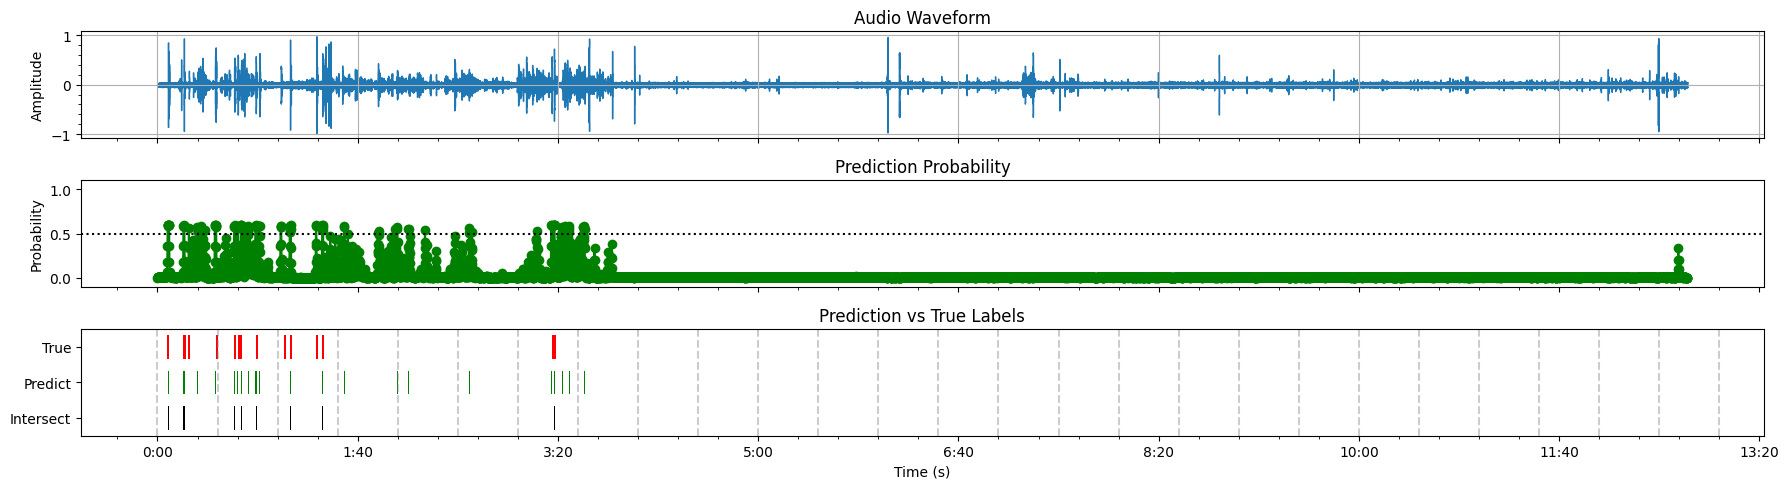

In [ ]:
#################################################################################
# Main
#################################################################################
def plot_intervals(ax, intervals, y, color, label=None):
    for start, end in intervals:
        ax.barh(y=y, width=end - start, left=start, height=0.2, color=color, label=label)
        
# Function to compute intersection of two interval lists
def compute_intersection(intervals1, intervals2):
    result = []
    for start1, end1 in intervals1:
        for start2, end2 in intervals2:
            start = max(start1, start2)
            end = min(end1, end2)
            if start < end:  # valid overlap
                result.append([start, end])
    return result

results_all = []
for filepath in tqdm(list_filepath):

    filename = filepath.split('/')[-1]
    print(filename)

    # Load data
    # (y, sr) = librosa.load(filepath, duration=180) # mono=True
    (y, sr) = librosa.load(filepath) # mono=True
    duration = librosa.get_duration(y=y, sr=sr)

    # Get time interval
    time_intervals = np.arange(0, duration - segment_length + 2*step_size, step_size)

    if if_plot == True:
        print('Duration:', duration)
        # print('Time:', time_intervals)
    
    segment_samples = int(segment_length * sr)
    step = segment_samples * (1 - overlap)

    label_onset = [0 for i in range(len(time_intervals))]

    label_pred = []
    label_pred_proba = []
    list_threshold_amplitude_mean = []

    #################################################################################
    # Looping through segments
    #################################################################################
    if len(label_onset) != 0:
        # for start_sample in np.arange(0, len(y) - step, step):
        for start_sample in tqdm(np.arange(0, len(y), step), position=0, leave=True):
            start_sample = int(start_sample)  # convert to int index
            segment = y[start_sample:start_sample + segment_samples]

            if len(segment) < segment_samples:
                padding = np.zeros(segment_samples - len(segment))
                segment = np.concatenate((segment, padding))

            mean = np.mean(np.abs(segment))
            
            #################################################################################
            # Extract Features and predict
            #################################################################################
            if mean <= threshold_amplitude_mean:
                list_threshold_amplitude_mean.append(0)
            else:
                list_threshold_amplitude_mean.append(1)
                
            #################################################################################
            # Get probabilities
            #################################################################################
            if mean <= threshold_amplitude_mean:
                pred_proba = np.array([1, 0])
                pred = 0
                
            # Whisper
            elif model_name == 'Whisper':                    
                # Calculate new number of samples
                new_length = int(len(segment) * 16000 / 22500)
                segment = resample(segment, new_length)
                
                segment_np = segment.astype(np.float32)
                inputs = processor(segment_np, sampling_rate=16000, return_tensors="pt")
                input_features = inputs.input_features.to(device)
            
                with torch.no_grad():
                    logits = model(input_features)
                    probabilities = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()[0]
                    pred = int(probabilities[1] >= threshold_proba)
                    pred_proba = probabilities

            # CNN
            elif model_name == 'CNN':
                result_row = extract_features_CNN(segment, sr, segment_length)
                result_row = np.array(result_row[0]).reshape((1, dim_first,  dimension_dictionary[segment_length]))
                result_row = result_row[..., np.newaxis]

                result_row = np.array(result_row)
                result_row = np.nan_to_num(result_row, nan=0)

                pred_proba = model.predict(result_row, verbose=0)[0]
                pred = np.argmax(pred_proba)
                # pred = pred_proba[1]

            # ML / NN
            elif model_name in ['LR', 'DT', 'RF', 'SVM', 'KNN', 'NB', 'NN', 'GB', 'Keras_NN']:
                result_row = extract_features(segment, sr)
                result_row = pd.DataFrame([result_row], columns=columns_features)
                for col in column_drop:
                    if col in result_row.columns:
                        result_row = result_row.drop([col], axis=1)
                result_row = np.array(result_row)[0]
                result_row = np.nan_to_num(result_row, nan=0)
                result_row = scaler.transform(result_row.reshape(1, -1))

                # NN
                if model_name in ['Keras_NN']:
                    pred_proba = model.predict(result_row)
                    pred = np.argmax(pred_proba, axis=1)

                # ML
                else:
                    pred_proba = model.predict_proba(result_row)
                    # label_pred = np.argmax(pred_proba, axis=1)
                    pred = (pred_proba[:, 1] >= threshold_proba).astype(int)[0]
                    pred_proba = list(pred_proba[0])

            label_pred.append(pred)
            label_pred_proba.append(pred_proba)

        label_pred_proba = np.array(label_pred_proba)
        label_pred_proba = label_pred_proba[:, 1]
        
        # Preprocessing
        label_pred_proba_raw = label_pred_proba.copy() # Keep copy of raw signal
        # for _ in range(10):
        for _ in range(5):
            label_pred_proba = mean_filter_same_length(label_pred_proba, threshold_mean_filter) # Smoothen signal
        label_pred = (np.array(label_pred_proba) >= threshold_proba).astype(int) # Get binary outputs
        
        label_pred = remove_amplitude_threshold(label_pred, list_threshold_amplitude_mean) # Drop low ampliutes -> Was commented in OG
        label_pred = fill_short_gaps(label_pred, threshold=1) # Fill in short gaps -> Was commented in OG
        label_pred = remove_isolated_detection(label_pred, max_length_sequence=threshold_isolate) # Remove isolated detection -> Was commented in OG

        # Convert into intervals
        # label_onset_interval = binary_to_intervals(label_onset, time_step=segment_length) # Onset so no overlap
        label_onset_interval = label_onset_manual.copy()
        label_pred_interval = binary_to_intervals(label_pred, time_step=step_size) # Pred so overlap
        
        label_pred_interval = merge_close_intervals(label_pred_interval, threshold_max_gap) # Merge close intervals
        label_cough_interval_intersect = interval_intersection(label_onset_interval, label_pred_interval)
        
        # Convert back
        label_onset = intervals_to_binary(label_onset_interval, len(label_onset), segment_length) # Onset so no overlap
        label_pred = intervals_to_binary(label_pred_interval, len(label_pred), step_size) # Pred so overlap

        audio_information = {
            'filepath': filepath,
            'filename': filename,
            'label': 1,
            'segment_length': segment_length,
            'overlap': overlap,
            'label_onset': label_onset,
            'label_pred': label_pred,
            'len': len(label_onset),
            'duration': duration,
            'threshold_proba': threshold_proba,
            'threshold_amplitude_mean': threshold_amplitude_mean,
            'threshold_overlap': threshold_overlap,
            'threshold_max_gap': threshold_max_gap,
            'label_onset_interval': label_onset_interval,
            'label_pred_interval': label_pred_interval,
        }
        
        metrics_event = evaluate_intervals_event_based(label_pred_interval, label_onset_interval, duration, overlap_threshold=threshold_overlap)
        metrics_duration = evaluate_intervals_duration_based(label_pred_interval, label_onset_interval, duration)
        metrices_combined = {**audio_information, **metrics_event, **metrics_duration}

        if if_plot == True:
            list_print = ['label_onset_interval', 'label_pred_interval', 'SEN_d', 'SPE_d', 'PRE_d', 'F1_d', 'FAR_d', 'PRE_e', 'REC_e', 'F1_e', 'FAR_e']
            for key in list_print:
                print(f'{key}: {metrices_combined[key]}')

        results_all.append(metrices_combined)

        if if_plot == True:
            # Create a figure with subplots
            fig, axs = plt.subplots(3, 1, figsize=(18, 5), sharex=True)
            
            # Plot waveform
            librosa.display.waveshow(y, sr=sr, ax=axs[0])
            axs[0].set_title('Audio Waveform')
            axs[0].set_xlabel('')
            axs[0].set_ylabel('Amplitude')
            axs[0].grid(True)
            axs[0].minorticks_on()  # Enable minor ticks for finer control
    
            # Plot waveform
            time_intervals =np.linspace(0, duration, len(label_pred_proba), endpoint=False)
            axs[1].plot(time_intervals, label_pred_proba, color='green', marker='o')
            axs[1].axhline(y=threshold_proba, linestyle=':', color='black')  # dotted horizontal line at y=0.5
            axs[1].set_ylim(-0.1, 1.1)
            axs[1].set_title('Prediction Probability')
            axs[1].set_ylabel('Probability')
  
            # Plot onset (red), pred (blue), and intersection (purple)
            plot_intervals(axs[2], label_onset_interval, y=0.8, color='red', label='True')
            plot_intervals(axs[2], label_pred_interval, y=0.5, color='green', label='Predict')
            plot_intervals(axs[2], label_cough_interval_intersect, y=0.2, color='black', label='Intersect')

            # Add vertical lines every minute (60 seconds)
            minute_marks = np.arange(0, duration + 30, 30)
            
            for t in minute_marks:
                axs[2].axvline(x=t, color='gray', linestyle='--', alpha=0.4)
            
            axs[2].set_title('Prediction vs True Labels')
            axs[2].set_ylim(0.05, 0.95)
            axs[2].set_yticks([0.2, 0.5, 0.8])
            axs[2].set_yticklabels(['Intersect', 'Predict', 'True'])
            axs[2].set_xlabel('Time (s)')

            plt.tight_layout()
            plt.show()
    
            # Play audio
            display(Audio(data=y, rate=sr))

if not os.path.exists(f'Results_Onset_Test/Results_Metrics'):
    os.makedirs(f'Results_Onset_Test/Results_Metrics')
results_all = pd.DataFrame(results_all, columns=metrices_combined.keys())

if if_save == True:
    results_all.to_csv(f'Results_Onset_Test/Results_Metrics/results_onset_metrics_{segment_length}s_{model_name}.csv', index=False)

In [ ]:
print(label_pred)

# Combine all data

In [ ]:
# Create an empty DataFrame to hold the combined data
combined_df = pd.DataFrame()

# Loop through each file and concatenate
for segment_length in [0.2]:
    df = pd.read_csv(f'Results_Onset_Test/Results_Metrics/results_onset_metrics_{segment_length}s_{model_name}_Summary_All.csv')
    combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df = combined_df[[
    'window_length', 'model', 'type', 
    'PRE_e', 'REC_e', 'F1_e', 'FAR_e', 'FARh_e',
    'SEN_d', 'SPE_d', 'PRE_d', 'F1_d', 'FAR_d', 'FARh_d',
]]

# Display or save the result
print(combined_df)
combined_df.to_csv(f'Results_Onset_Test/Results_Metrics/results_onset_metrics_{model_name}_Summary_All.csv', index=False)